# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
# @title Install dependencies
!pip install nilearn --quiet
!pip install nltools --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc
from nltools.utils import get_resource_path
from nltools.file_reader import onsets_to_dm
from nltools.data import Design_Matrix
from nilearn import datasets, plotting

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [ ]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='int')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


# def load_evs(subject, experiment, run):
#   """Load EVs (explanatory variables) data for one task experiment.

#   Args:
#     subject (str): subject ID to load
#     experiment (str) : Name of experiment
#     run (int): 0 or 1

#   Returns
#     evs (list of lists): A list of frames associated with each condition

#   """
#   frames_list = []
#   task_key = f'tfMRI_{experiment}_{RUNS[run]}'
#   for cond in EXPERIMENTS[experiment]['cond']:
#     ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
#     ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
#     ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
#     # Determine when trial starts, rounded down
#     start = np.floor(ev["onset"] / TR).astype(int)
#     # Use trial duration to determine how many frames to include for trial
#     duration = np.ceil(ev["duration"] / TR).astype(int)
#     # Take the range of frames that correspond to this specific trial
#     frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
#     frames_list.append(frames)

#   return frames_list

In [ ]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

# DM


We want to create a decoding GLM for each participant for the 2-back and 0-back tasks. The GLM predict spikes from when the stimulus is active. The stimulus is specified in the EV which becomes the Design Matrix


In [ ]:
conditions = EXPERIMENTS['WM']['cond']
cols = ['Onset', 'Duration', 'Stim']
TR = 0.72 #Repetition time. fmri data is a 3d volume scanned by taking many 2d images over time. 720 ms for each 3d volume to be scanned once.
n_tr = 405 #There are 405 time points for each slice to get scanned

In [ ]:
# Example for a single subject
s = 100408

#subject_data_list = []
data = load_single_timeseries(s, 'WM', 0, remove_mean=True)
#for s in subjects:
rows = []
for condition in conditions:
  data_dir = '/content/hcp_task/subjects/' + str(s) + '/WM/tfMRI_WM_LR/EVs/' + condition + '.txt'
  subject_data = pd.read_csv(data_dir, names=cols, sep='\t')

  # replace boolean Stim with condition name
  subject_data.Stim = condition
  rows.append(subject_data.to_numpy().squeeze())
full_data_one_subject = pd.DataFrame(rows,columns=cols)
full_data_one_subject

,Onset,Duration,Stim
0,38.665,27.5,0bk_body
1,224.389,27.5,0bk_faces
2,252.605,27.5,0bk_places
3,109.982,27.5,0bk_tools
4,153.072,27.5,2bk_body
5,81.781,27.5,2bk_faces
6,181.167,27.5,2bk_places
7,10.569,27.5,2bk_tools


In [ ]:
dm = onsets_to_dm(full_data_one_subject, sampling_freq=1/TR, run_length=405)
dm

# has 405 rows for 405 timepoints
# matrix contains mostly zeros because a condition is only active for a short period of time

,0bk_body,0bk_faces,0bk_places,0bk_tools,2bk_body,2bk_faces,2bk_places,2bk_tools
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

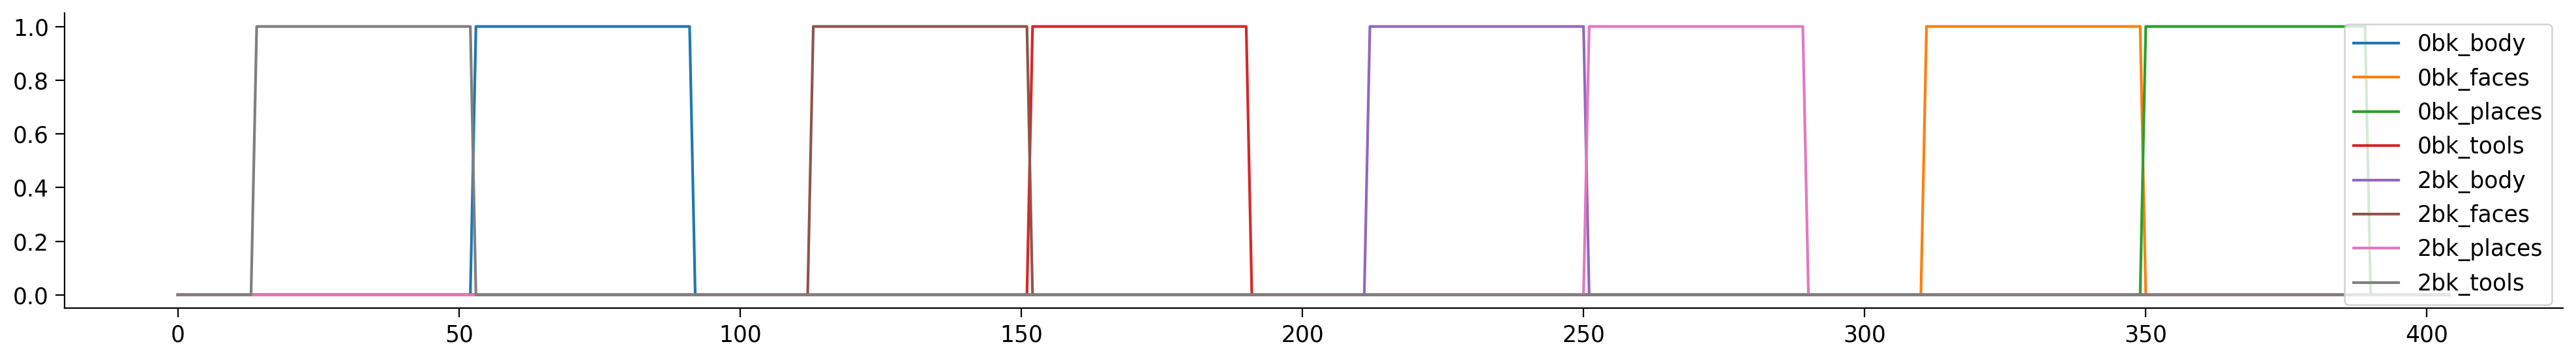

In [ ]:
# dm.plot is a method which plots the time for when each stimuli is active. 0 = off. 1 = on.

f,a= plt.subplots(figsize=(20,3))
dm.plot(ax=a)

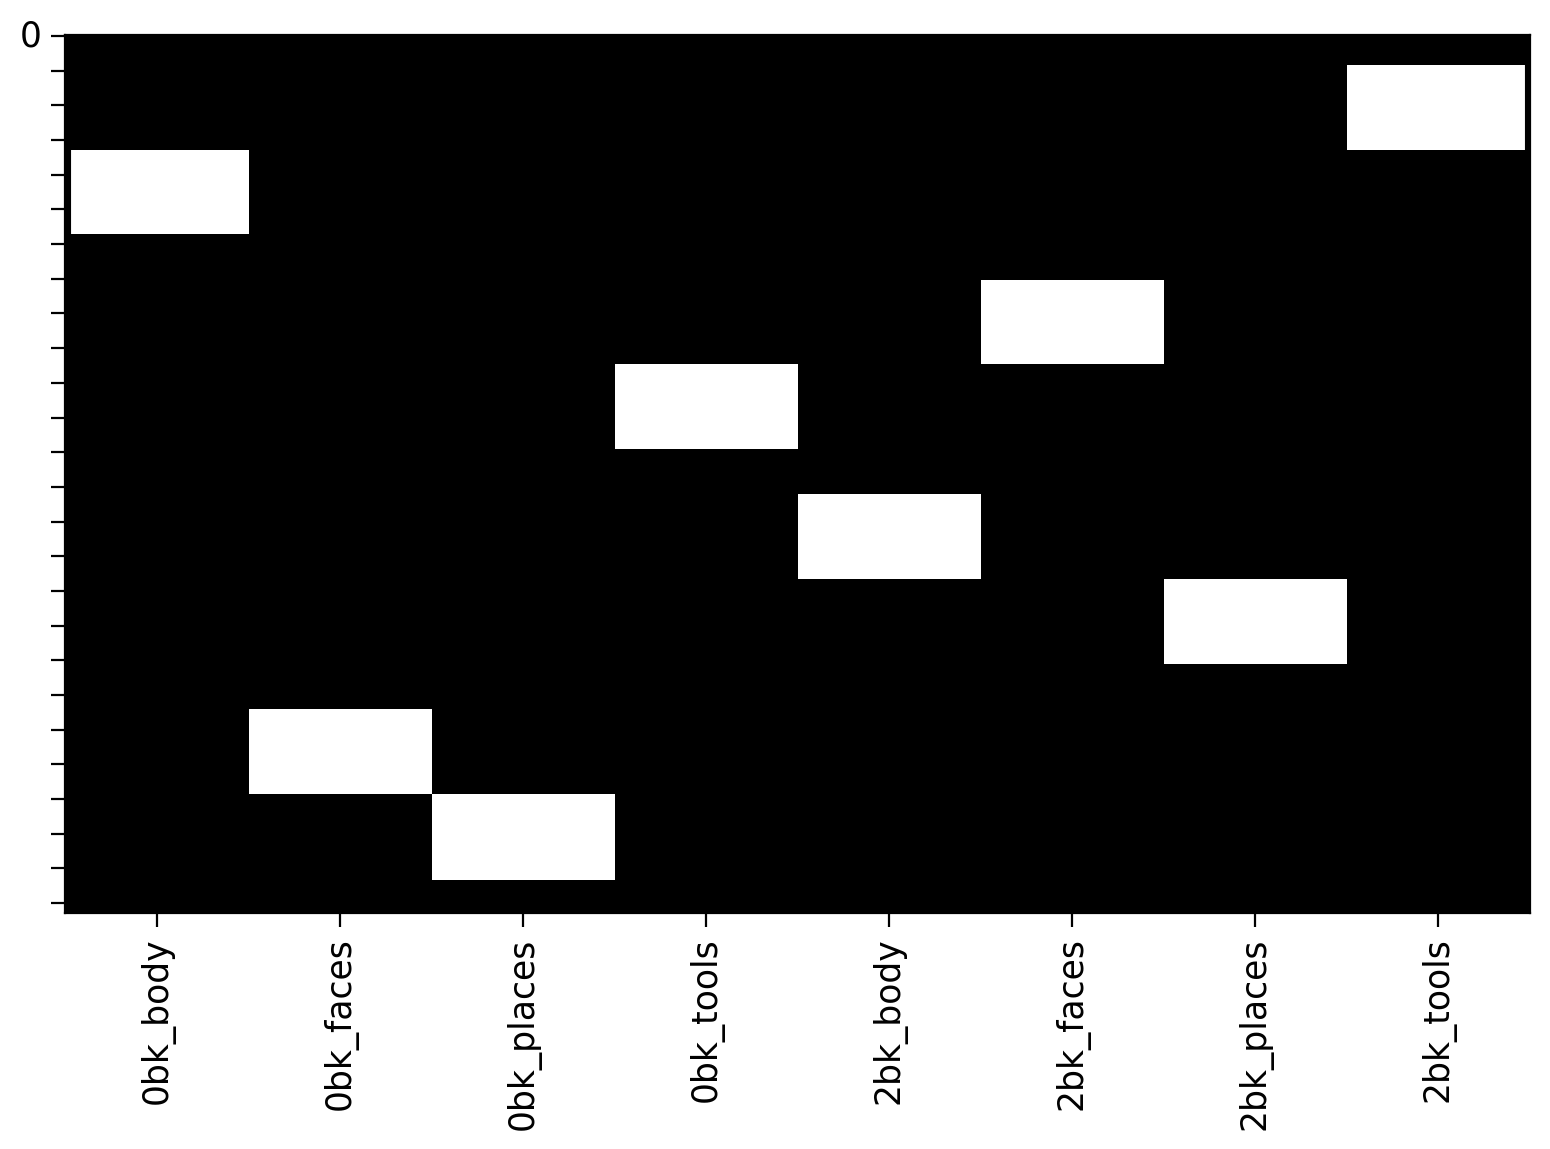

In [ ]:
dm.heatmap()

<Axes: >

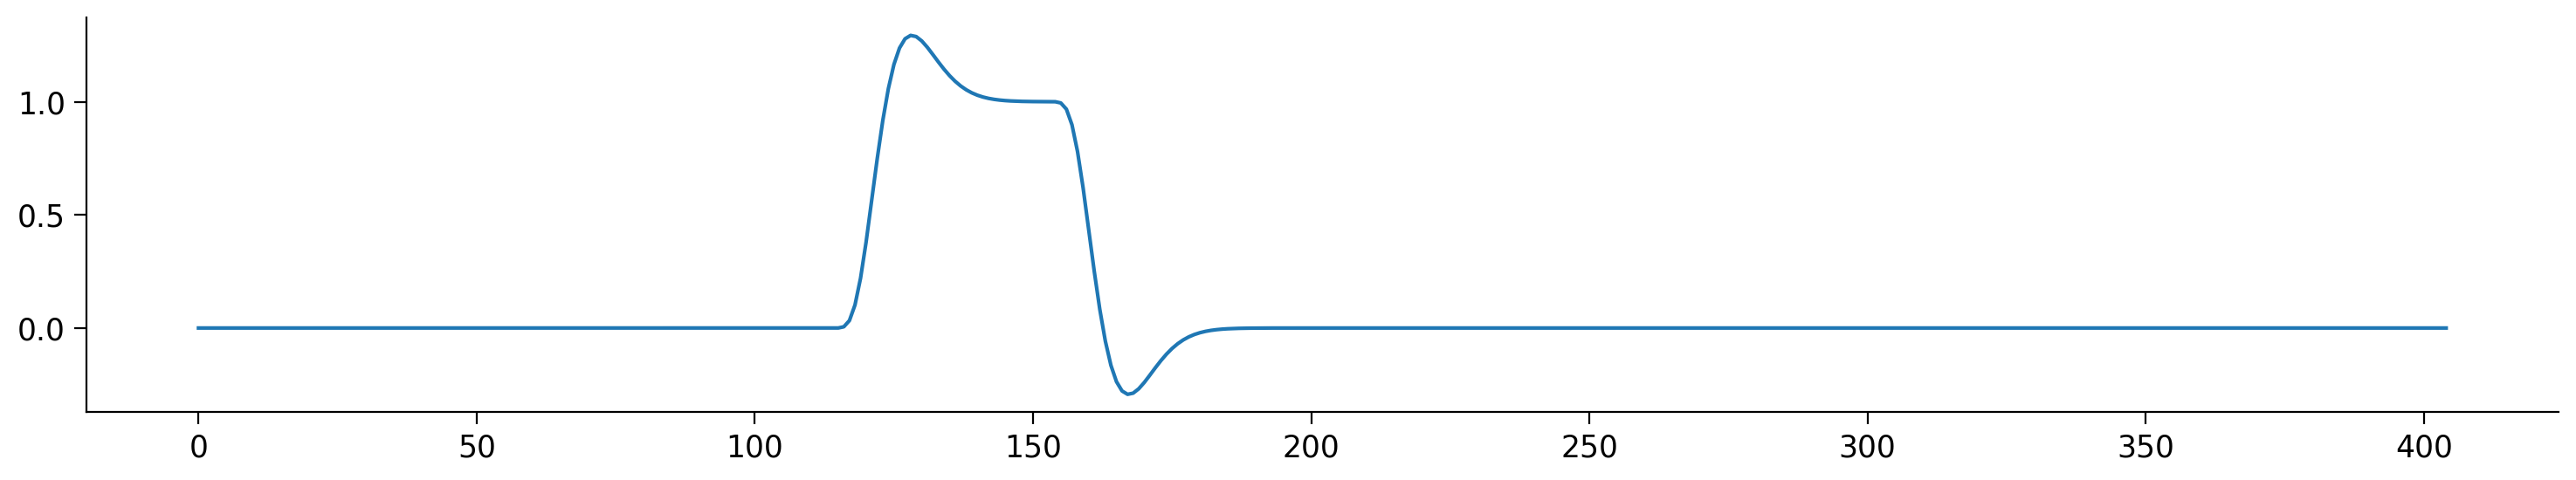

In [ ]:
dm_conv = dm.convolve()
dm_conv ['Intercept'] = 1
# in fmri, we are recording bold signal which lags behind the true activity. We use convolve to reduce the time lag in recording.
# we also convert discrete values into continuous ones
# blurrier and shades resemble the amplitude of the hemodynamic response function (HRF)

# plot example for single stimulus
f,a = plt.subplots(figsize=(15,3))
dm_conv['2bk_faces_c0'].plot(ax=a)

# GLM

In [ ]:
import statsmodels.api as sm

# example for single subject, single region
gamma_model = sm.GLM(endog=data[21], exog=dm_conv, family=sm.families.Gaussian())
gamma_results = gamma_model.fit()
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  405
Model:                            GLM   Df Residuals:                      396
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                          6407.1
Method:                          IRLS   Log-Likelihood:                -2345.1
Date:                Sun, 30 Jul 2023   Deviance:                   2.5372e+06
Time:                        10:10:32   Pearson chi2:                 2.54e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4217
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
0bk_body_c0      87.5459     14.190      6.170

In [ ]:
# example for single subject
individual_subject = []
for roi in range(360):
  gamma_model = sm.GLM(endog=data[roi], exog=dm_conv, family=sm.families.Gaussian())
  gamma_results = gamma_model.fit()
  coefs = gamma_results.params
  pvalues = gamma_results.pvalues
  individual_subject.append((coefs,pvalues))

#print(np.shape(individual_subject))

In [ ]:
# Code for all subjects
cols = ['Onset', 'Duration', 'Stim']
all_subjects = []
for num, s in enumerate(subjects):
  # Load the fmri signals recorded--360 regions with 405 time points
  fmri_data = load_single_timeseries(s, 'WM', 0, remove_mean=True)
  data = load_single_timeseries(s, 'WM', 0, remove_mean=True)
  condition = []

  # load the EVs (explanatory variables): onset, duration and activation (1 or 0)
  for c in conditions:
    data_dir = '/content/hcp_task/subjects/' + str(s) + '/WM/tfMRI_WM_LR/EVs/'+ c + '.txt'
    subject_data = pd.read_csv(data_dir, names=cols,sep = '\t')
    # replace boolean Stim with condition name
    subject_data.Stim = c
    condition.append(subject_data.to_numpy().squeeze())
  full_data_one_subject = pd.DataFrame(condition, columns=cols)

  dm = onsets_to_dm(full_data_one_subject, sampling_freq=1/TR, run_length=405)
  dm_conv = dm.convolve()
  dm_conv ['Intercept'] = 1

  individual_subject = []

  # all rois
  for roi in range(360):
    gamma_model = sm.GLM(endog=data[roi], exog=dm_conv, family=sm.families.Gaussian())
    gamma_results = gamma_model.fit()
    coefs = gamma_results.params
    pvalues = gamma_results.pvalues
    individual_subject.append((coefs,pvalues))

  all_subjects.append((s, individual_subject))
  print(num/len(subjects),"/ 1")

0.0 / 1
0.01 / 1
0.02 / 1
0.03 / 1
0.04 / 1
0.05 / 1
0.06 / 1
0.07 / 1
0.08 / 1
0.09 / 1
0.1 / 1
0.11 / 1
0.12 / 1
0.13 / 1
0.14 / 1
0.15 / 1
0.16 / 1
0.17 / 1
0.18 / 1
0.19 / 1
0.2 / 1
0.21 / 1
0.22 / 1
0.23 / 1
0.24 / 1
0.25 / 1
0.26 / 1
0.27 / 1
0.28 / 1
0.29 / 1
0.3 / 1
0.31 / 1
0.32 / 1
0.33 / 1
0.34 / 1
0.35 / 1
0.36 / 1
0.37 / 1
0.38 / 1
0.39 / 1
0.4 / 1
0.41 / 1
0.42 / 1
0.43 / 1
0.44 / 1
0.45 / 1
0.46 / 1
0.47 / 1
0.48 / 1
0.49 / 1
0.5 / 1
0.51 / 1
0.52 / 1
0.53 / 1
0.54 / 1
0.55 / 1
0.56 / 1
0.57 / 1
0.58 / 1
0.59 / 1
0.6 / 1
0.61 / 1
0.62 / 1
0.63 / 1
0.64 / 1
0.65 / 1
0.66 / 1
0.67 / 1
0.68 / 1
0.69 / 1
0.7 / 1
0.71 / 1
0.72 / 1
0.73 / 1
0.74 / 1
0.75 / 1
0.76 / 1
0.77 / 1
0.78 / 1
0.79 / 1
0.8 / 1
0.81 / 1
0.82 / 1
0.83 / 1
0.84 / 1
0.85 / 1
0.86 / 1
0.87 / 1
0.88 / 1
0.89 / 1
0.9 / 1
0.91 / 1
0.92 / 1
0.93 / 1
0.94 / 1
0.95 / 1
0.96 / 1
0.97 / 1
0.98 / 1
0.99 / 1


# Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
behavior_data = pd.read_csv('behavior_data.csv')
int_subjects = [int(i) for i in subjects]
behavior_data = behavior_data.loc[behavior_data['Subject'].isin(int_subjects)]
interesting = behavior_data[['Subject','NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']] #A list of column names
# Don't need to normalize since the max value for all traits is the same
# X_normalize = StandardScaler().fit_transform(X)

In [ ]:
X = interesting[['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']]

In [ ]:
interesting

,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
2,100307,37.0,24.0,35.0,15.0,37.0
3,100408,33.0,29.0,34.0,15.0,33.0
11,101915,35.0,30.0,45.0,8.0,31.0
18,102816,36.0,27.0,32.0,10.0,31.0
22,103414,27.0,30.0,31.0,20.0,34.0
...,...,...,...,...,...,...
534,199655,24.0,29.0,33.0,15.0,28.0
541,200614,42.0,22.0,43.0,9.0,38.0
544,201111,36.0,35.0,42.0,31.0,23.0
545,201414,41.0,37.0,37.0,8.0,38.0


In [ ]:
# #Simple PCA of the data
# pca = PCA(n_components=2)

# principalComponents = pca.fit_transform(X)

# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

# principalDf

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

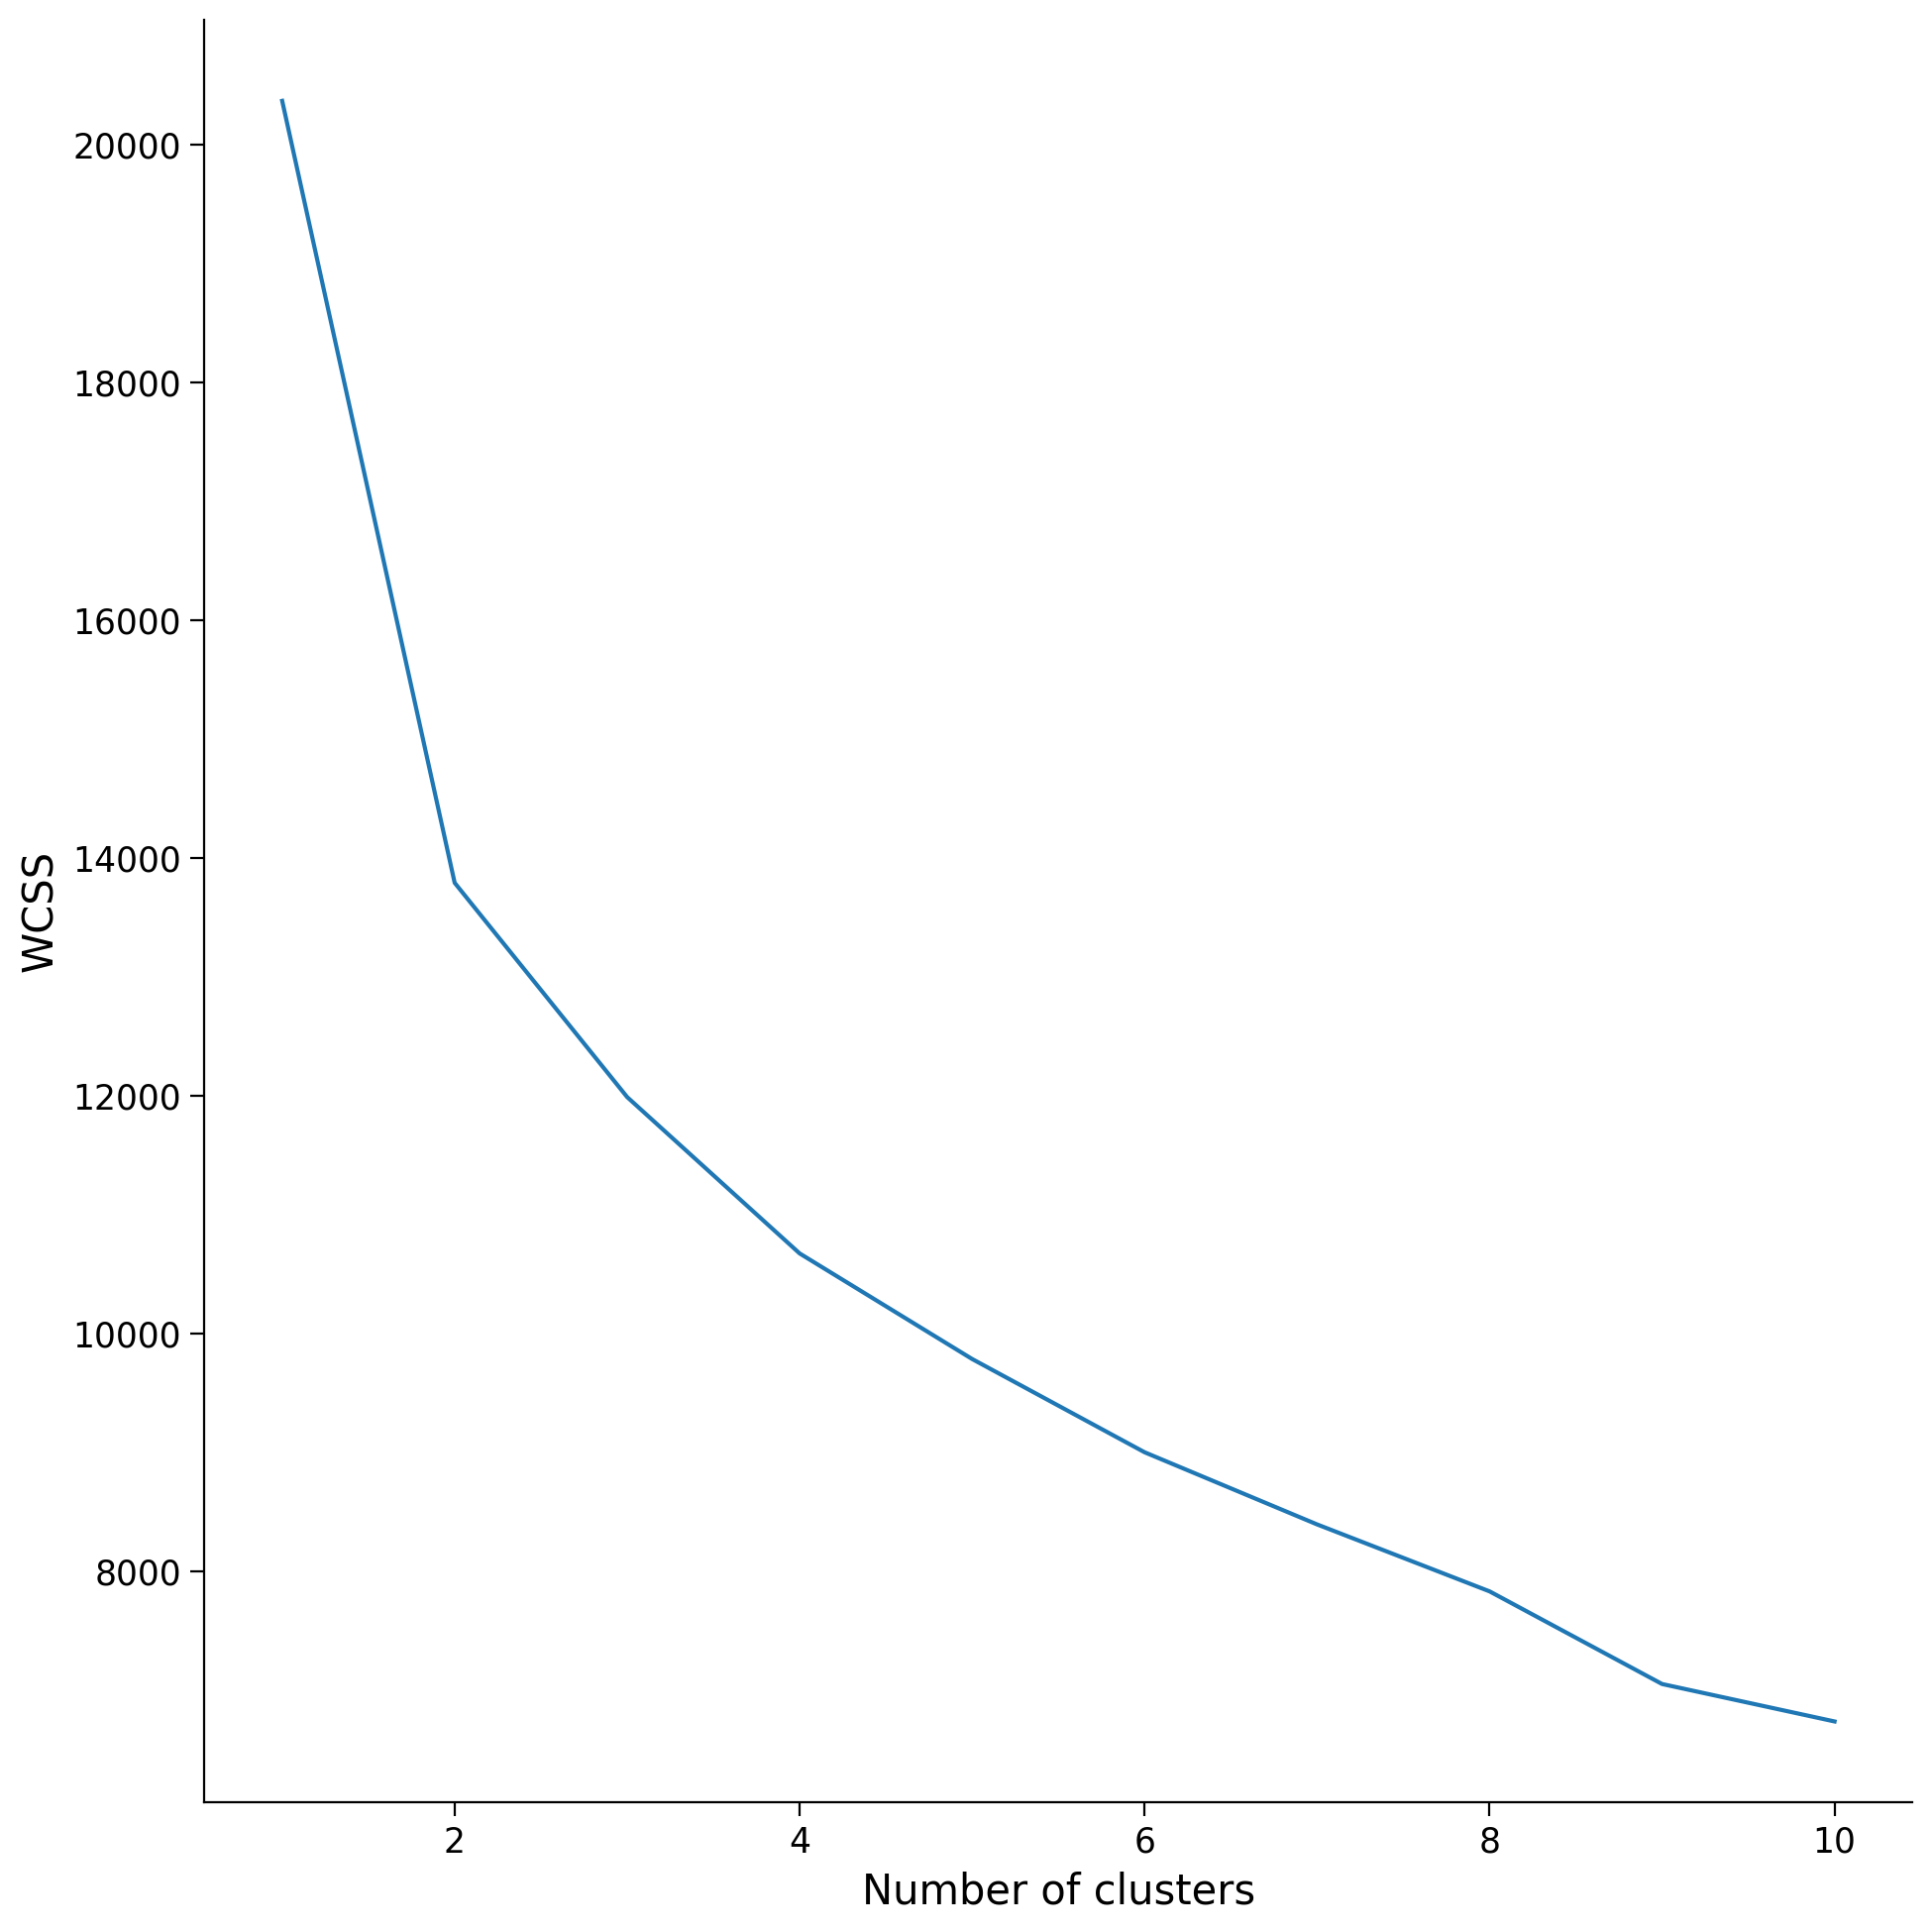

In [ ]:
#Elbow curve for k-means clustering

wcss = []
for i in range(1,11):
   model = KMeans(n_clusters = i, init = "k-means++")
   model.fit(X)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Desired k-means clustering model

no_of_cluster = 2

kmeans = KMeans(n_clusters=no_of_cluster, n_init=2023)

y = kmeans.fit_predict(X)

X['Cluster'] = y

y

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0], dtype=int32)

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 10.188458
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.057095
[t-SNE] KL divergence after 300 iterations: 0.234676


<ipython-input-26-f7d331ddce19>:12: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='tsne_1', ylabel='tsne_2'>

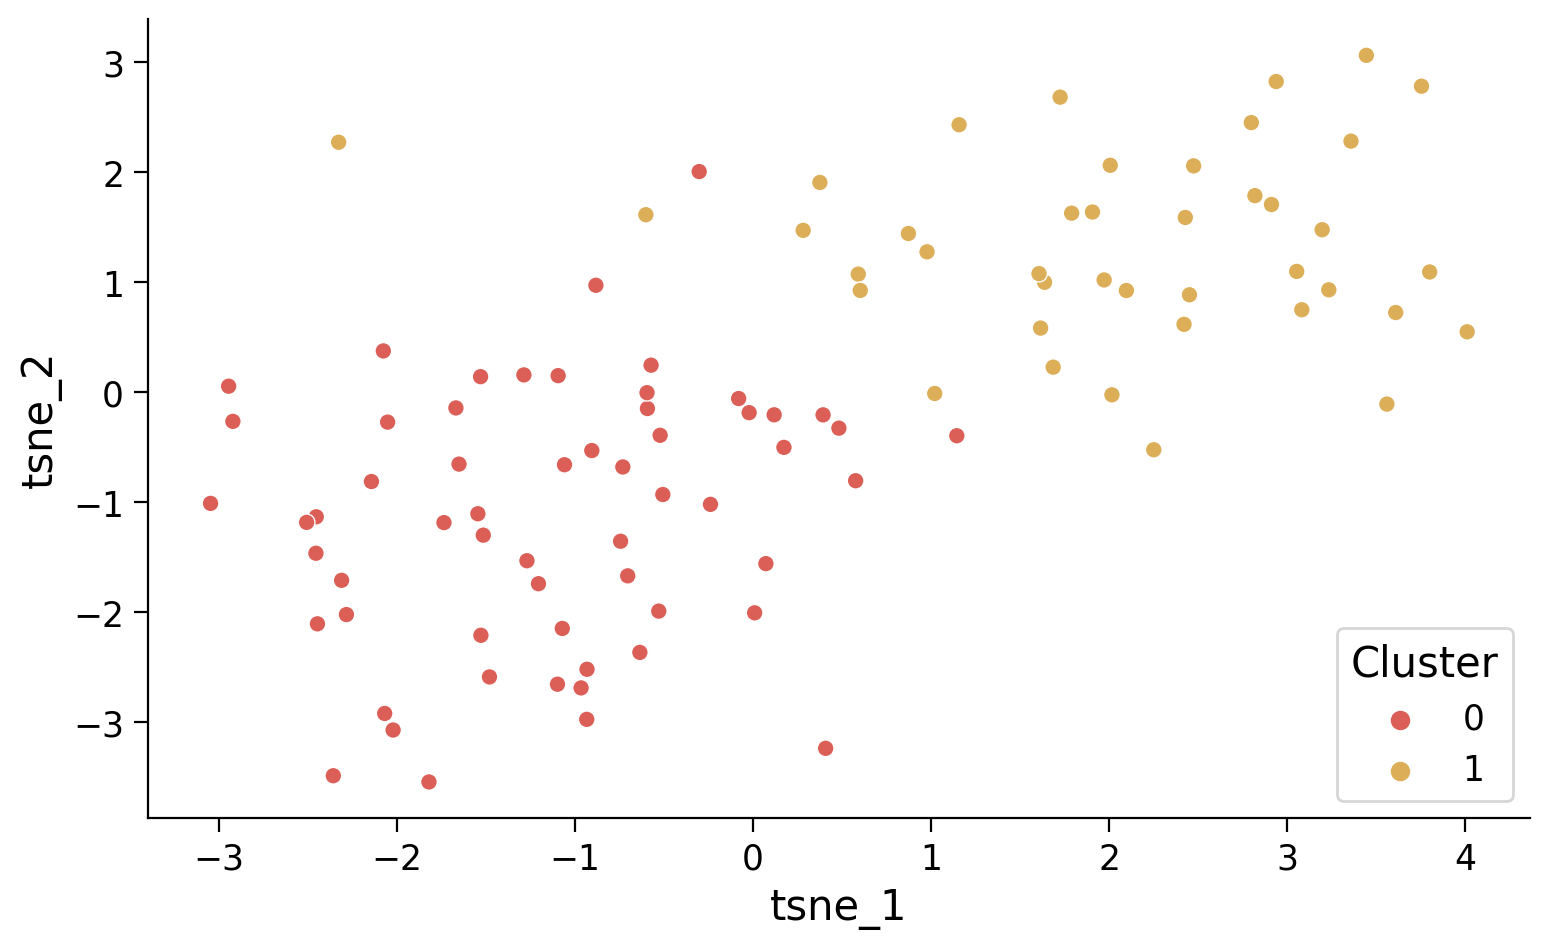

In [ ]:
# TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(X)

tsne_1 = tsne_results[:,0]
tsne_2 = tsne_results[:,1]

X['tsne_1'] = tsne_1
X['tsne_2'] = tsne_2

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="Cluster",
    palette=sns.color_palette("hls", 10),
    data=X,
    legend="full",
    alpha=1
)

In [ ]:
# Cluster Analysis

# Splitting based on k-means clusters and t-test on the data
from scipy.stats import ttest_ind

#X['Subject'] = interesting['Subject']
cluster1 = X.loc[X['Cluster'] == 0]
cluster2 = X.loc[X['Cluster'] == 1]

t_test = ttest_ind(cluster1, cluster2)
print(t_test.pvalue)

[4.57610822e-12 3.90979008e-01 4.83433662e-07 3.60457441e-16
 1.86311319e-12 0.00000000e+00 5.27132395e-25 4.29547218e-20]


<ipython-input-27-50e16373954b>:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_test = ttest_ind(cluster1, cluster2)


In [ ]:
X

,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E,Cluster,tsne_1,tsne_2
2,37.0,24.0,35.0,15.0,37.0,0,-1.651766,-0.654058
3,33.0,29.0,34.0,15.0,33.0,0,-0.593412,-0.148599
11,35.0,30.0,45.0,8.0,31.0,0,-0.966089,-2.689492
18,36.0,27.0,32.0,10.0,31.0,0,-0.905737,-0.530880
22,27.0,30.0,31.0,20.0,34.0,1,0.590948,1.073876
...,...,...,...,...,...,...,...,...
534,24.0,29.0,33.0,15.0,28.0,1,0.977168,1.276630
541,42.0,22.0,43.0,9.0,38.0,0,-2.446896,-2.106674
544,36.0,35.0,42.0,31.0,23.0,1,4.011003,0.549236
545,41.0,37.0,37.0,8.0,38.0,0,-2.021780,-3.072430


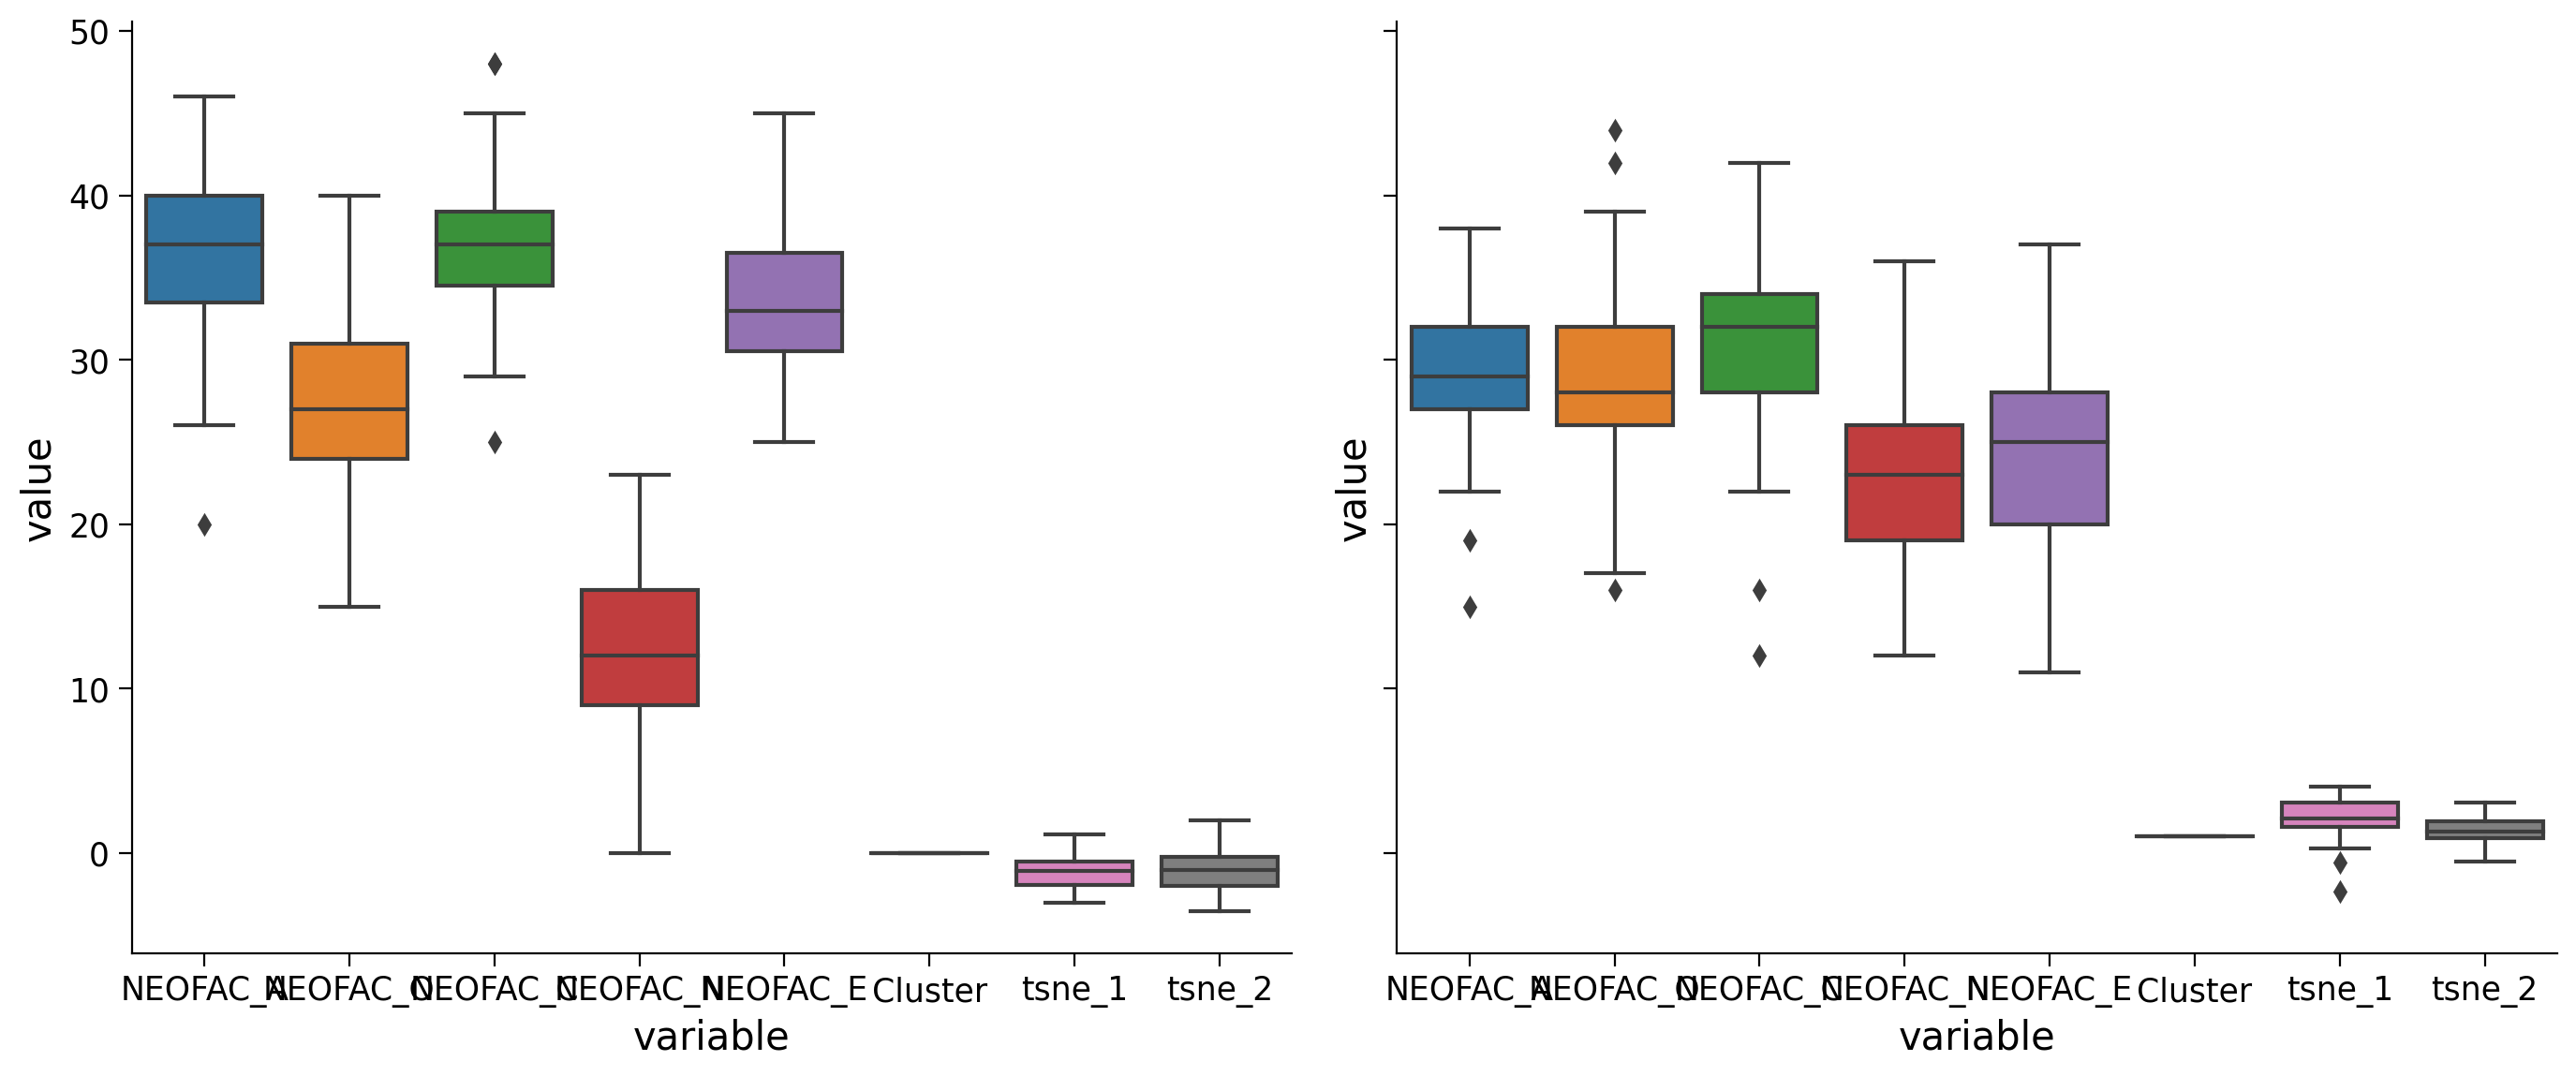

In [ ]:
# Unfinished boxplotting of the data
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(cluster1), ax=ax1)
sns.boxplot(x="variable", y="value", data=pd.melt(cluster2), ax=ax2)
plt.show()

In [ ]:
# Splitting based on k-means clusters and t-test on the data
from scipy.stats import ttest_ind

X['Subject'] = interesting['Subject']
cluster1 = X.loc[X['Cluster'] == 0]
cluster2 = X.loc[X['Cluster'] == 1]

t_test = ttest_ind(cluster1, cluster2)
print(t_test.pvalue)

[4.57610822e-12 3.90979008e-01 4.83433662e-07 3.60457441e-16
 1.86311319e-12 0.00000000e+00 5.27132395e-25 4.29547218e-20
 7.33018967e-01]


<ipython-input-30-daae5fb7e8c4>:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_test = ttest_ind(cluster1, cluster2)


In [ ]:
X #Subject added

,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E,Cluster,tsne_1,tsne_2,Subject
2,37.0,24.0,35.0,15.0,37.0,0,-1.651766,-0.654058,100307
3,33.0,29.0,34.0,15.0,33.0,0,-0.593412,-0.148599,100408
11,35.0,30.0,45.0,8.0,31.0,0,-0.966089,-2.689492,101915
18,36.0,27.0,32.0,10.0,31.0,0,-0.905737,-0.530880,102816
22,27.0,30.0,31.0,20.0,34.0,1,0.590948,1.073876,103414
...,...,...,...,...,...,...,...,...,...
534,24.0,29.0,33.0,15.0,28.0,1,0.977168,1.276630,199655
541,42.0,22.0,43.0,9.0,38.0,0,-2.446896,-2.106674,200614
544,36.0,35.0,42.0,31.0,23.0,1,4.011003,0.549236,201111
545,41.0,37.0,37.0,8.0,38.0,0,-2.021780,-3.072430,201414


In [ ]:
all_subjects[4][1][0][0]['2bk_body_c0']  # subject,glmvalues,ROI,coefs/pvalues,condition

full_rois = []

cluster1_avg_beta_body = []
cluster1_avg_beta_faces = []
cluster1_avg_beta_tools = []
cluster1_avg_beta_places = []

cluster2_avg_beta_body = []
cluster2_avg_beta_faces = []
cluster2_avg_beta_tools = []
cluster2_avg_beta_places = []

cluster1_full_rois_body = []
cluster1_full_rois_faces = []
cluster1_full_rois_tools = []
cluster1_full_rois_places = []

cluster2_full_rois_body = []
cluster2_full_rois_faces = []
cluster2_full_rois_tools = []
cluster2_full_rois_places = []


for roi in range(360):
    cluster1_full_data_body = []
    cluster2_full_data_body = []
    cluster1_avg_body = 0
    cluster2_avg_body = 0
    cluster1_full_data_faces = []
    cluster2_full_data_faces = []
    cluster1_avg_faces = 0
    cluster2_avg_faces = 0
    cluster1_full_data_tools = []
    cluster2_full_data_tools = []
    cluster1_avg_tools = 0
    cluster2_avg_tools = 0
    cluster1_full_data_places = []
    cluster2_full_data_places = []
    cluster1_avg_places = 0
    cluster2_avg_places = 0
    for s in range(100):
      beta_value_body = all_subjects[s][1][roi][0]['2bk_body_c0'] - all_subjects[s][1][roi][0]['0bk_body_c0']
      beta_value_faces = all_subjects[s][1][roi][0]['2bk_faces_c0'] - all_subjects[s][1][roi][0]['0bk_faces_c0']
      beta_value_tools = all_subjects[s][1][roi][0]['2bk_tools_c0'] - all_subjects[s][1][roi][0]['0bk_tools_c0']
      beta_value_places = all_subjects[s][1][roi][0]['2bk_places_c0'] - all_subjects[s][1][roi][0]['0bk_places_c0']
      if int(subjects[s]) in cluster1['Subject'].values:
        cluster1_avg_body += beta_value_body
        cluster1_full_data_body.append(beta_value_body)
        cluster1_avg_faces += beta_value_faces
        cluster1_full_data_faces.append(beta_value_faces)
        cluster1_avg_tools += beta_value_tools
        cluster1_full_data_tools.append(beta_value_tools)
        cluster1_avg_places += beta_value_places
        cluster1_full_data_places.append(beta_value_places)
      else:
        cluster2_avg_body += beta_value_body
        cluster2_full_data_body.append(beta_value_body)
        cluster2_avg_faces += beta_value_faces
        cluster2_full_data_faces.append(beta_value_faces)
        cluster2_avg_tools += beta_value_tools
        cluster2_full_data_tools.append(beta_value_tools)
        cluster2_avg_places += beta_value_places
        cluster2_full_data_places.append(beta_value_places)

    cluster1_avg_body /= len(cluster1.index)
    cluster1_avg_faces /= len(cluster1.index)
    cluster1_avg_tools /= len(cluster1.index)
    cluster1_avg_places /= len(cluster1.index)

    cluster2_avg_body /= len(cluster2.index)
    cluster2_avg_faces /= len(cluster2.index)
    cluster2_avg_tools /= len(cluster2.index)
    cluster2_avg_places /= len(cluster2.index)

    cluster1_avg_beta_body.append(cluster1_avg_body)
    cluster1_avg_beta_faces.append(cluster1_avg_faces)
    cluster1_avg_beta_tools.append(cluster1_avg_tools)
    cluster1_avg_beta_places.append(cluster1_avg_places)

    cluster2_avg_beta_body.append(cluster2_avg_body)
    cluster2_avg_beta_faces.append(cluster2_avg_faces)
    cluster2_avg_beta_tools.append(cluster2_avg_tools)
    cluster2_avg_beta_places.append(cluster2_avg_places)

    cluster1_full_rois_body.append(cluster1_full_data_body)
    cluster1_full_rois_faces.append(cluster1_full_data_faces)
    cluster1_full_rois_tools.append(cluster1_full_data_tools)
    cluster1_full_rois_places.append(cluster1_full_data_places)

    cluster2_full_rois_body.append(cluster2_full_data_body)
    cluster2_full_rois_faces.append(cluster2_full_data_faces)
    cluster2_full_rois_tools.append(cluster2_full_data_tools)
    cluster2_full_rois_places.append(cluster2_full_data_places)

In [ ]:
cluster1_full_rois_body = np.array(cluster1_full_rois_body)
cluster1_full_rois_faces = np.array(cluster1_full_rois_faces)
cluster1_full_rois_tools = np.array(cluster1_full_rois_tools)
cluster1_full_rois_places = np.array(cluster1_full_rois_places)
cluster2_full_rois_body = np.array(cluster2_full_rois_body)
cluster2_full_rois_faces = np.array(cluster2_full_rois_faces)
cluster2_full_rois_tools = np.array(cluster2_full_rois_tools)
cluster2_full_rois_places = np.array(cluster2_full_rois_places)

t_test_body = ttest_ind(cluster1_full_rois_body.T, cluster2_full_rois_body.T)
t_test_faces = ttest_ind(cluster1_full_rois_faces.T, cluster2_full_rois_faces.T)
t_test_tools = ttest_ind(cluster1_full_rois_tools.T, cluster2_full_rois_tools.T)
t_test_places = ttest_ind(cluster1_full_rois_places.T, cluster2_full_rois_places.T)

between_body = np.where(t_test_body.pvalue < 0.05)
between_faces = np.where(t_test_faces.pvalue < 0.05)
between_tools = np.where(t_test_tools.pvalue < 0.05)
between_places = np.where(t_test_places.pvalue < 0.05)

between_body, between_faces, between_tools, between_places

((array([ 98, 173, 237, 257, 320, 327]),),
 (array([ 42, 119]),),
 (array([ 21,  44,  46, 112, 134, 173, 182, 221, 264, 265, 291, 350]),),
 (array([ 10,  80, 104, 119, 147, 215, 234]),))

In [ ]:
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

full_rois_body = np.hstack((cluster1_full_rois_body, cluster2_full_rois_body))
full_rois_faces = np.hstack((cluster1_full_rois_faces, cluster2_full_rois_faces))
full_rois_tools = np.hstack((cluster1_full_rois_tools, cluster2_full_rois_tools))
full_rois_places = np.hstack((cluster1_full_rois_places, cluster2_full_rois_places))

single_t_body = ttest_1samp(full_rois_body.T, 0)
single_t_faces = ttest_1samp(full_rois_faces.T, 0)
single_t_tools = ttest_1samp(full_rois_tools.T, 0)
single_t_places = ttest_1samp(full_rois_places.T, 0)

pv_body = multipletests(single_t_body.pvalue)
pv_faces = multipletests(single_t_faces.pvalue)
pv_tools = multipletests(single_t_tools.pvalue)
pv_places = multipletests(single_t_places.pvalue)

important_body = np.where(pv_body[1] < 0.000001)
important_faces = np.where(pv_faces[1] < 0.00000001)
important_tools = np.where(pv_tools[1] < 0.000000001)
important_places = np.where(pv_places[1] < 0.000000003)


important_body_all = np.where(pv_body[1] < 0.0005)
important_faces_all = np.where(pv_faces[1] < 0.0005)
important_tools_all = np.where(pv_tools[1] < 0.0005)
important_places_all = np.where(pv_places[1] < 0.0005)
#np.intersect1d(between_body, important_body), np.intersect1d(between_faces, important_faces), np.intersect1d(between_tools, important_tools), np.intersect1d(between_places, important_places)

important_all = np.intersect1d(np.intersect1d(np.intersect1d(important_body_all, important_faces_all), important_tools_all),important_places_all)

important_body

(array([208, 210, 212, 274, 310]),)

In [ ]:
z = np.concatenate((important_all, important_places[0]))

z = np.unique(z)

In [ ]:
d = pd.read_excel('Glasser_2016_Table.xlsx') # Glasser parcellation data

area_names = d['Area\xa0Description'] # List of brain areas in parcellation

In [ ]:
for roi in z:
  if roi < 180:
    print(area_names[roi])
  else:
    print(area_names[roi-180])

Medial Area 7P
Area posterior  9-46v
Inferior 6-8
Transitional Area
Area IntraParietal 2
Area PFm Complex
Area posterior  9-46v
Area IntraParietal 2


In [ ]:
for roi in important_all:
  if roi < 180:
    print(area_names[roi])
  else:
    print(area_names[roi-180])

Medial Area 7P
Area posterior  9-46v
Inferior 6-8
Transitional Area
Area IntraParietal 2
Area IntraParietal 2


In [ ]:
area_names[274 - 180]

'Area Lateral\nIntraParietal dorsal'

In [ ]:
full_roi = np.zeros(360)
for roi in range(len(full_roi)):
  if roi in z:
    full_roi[roi] = 1

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = full_roi[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=1)



*   Clustered participants into two clusters based on personality traits
*   Clusters show statistically significant difference for 4 out of 5 traits (all but openness)
*   Computed GLMs for 8 different task conditions in single-subject manner
*   Compared GLM beta-regressor values across all 100 subjects by parameter estimation of 2-back-body condition against 0-back-body condition
*   Found many ROIs with statistically significant difference between 2-back and 0-back condition



# Prediction model

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
all_subjects[4][1][0][0]['2bk_body_c0']  # subject,glmvalues,ROI,coefs/pvalues --> this is how our data look like

64.07811461880183

In [ ]:
all_subjects[4][1][0][0][4]

64.07811461880183

In [ ]:
all_subjects[5][1][0][0]

0bk_body_c0        6.169596
0bk_faces_c0      45.641715
0bk_places_c0     72.834039
0bk_tools_c0      73.231257
2bk_body_c0       89.404394
2bk_faces_c0      71.299685
2bk_places_c0    106.464119
2bk_tools_c0      88.198120
Intercept        -53.649385
dtype: float64

In [ ]:
all_subjects[4][1][0][0][5]

88.71121865913405

In [ ]:
x_values = []

for i in range(len(subjects)):
  roi_list = []
  for roi in important_all:
    roi_list.append(all_subjects[i][1][roi][0][0]) # [roi0, roi0, ... roi4, roi4,...]
    roi_list.append(all_subjects[i][1][roi][0][4])
  x_values.append(roi_list)

In [ ]:
# x_values = np.array(x_values).reshape(-1, 1)

In [ ]:
# y_values = list(interesting['NEOFAC_N'])
# y_values = list(interesting['NEOFAC_A'])
# y_values = list(interesting['NEOFAC_O'])
y_values = list(interesting['NEOFAC_C']) # lowest MSE
# y_values = list(interesting['NEOFAC_E'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, random_state=104, test_size=0.25, shuffle=True)
log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred)

68.12

In [ ]:
pd.DataFrame([list(y_pred), y_test])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,28.0,43.0,22.0,31.0,48.0,28.0,37.0,37.0,37.0,31.0,...,31.0,32.0,34.0,28.0,45.0,43.0,45.0,43.0,34.0,38.0
1,29.0,45.0,34.0,31.0,29.0,30.0,26.0,37.0,37.0,30.0,...,28.0,34.0,35.0,39.0,30.0,37.0,42.0,33.0,40.0,35.0


In [ ]:
accuracies = cross_val_score(LogisticRegression(penalty=None), X, y, cv=8)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred)

28.496539999999996

# Tuning

In [ ]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, r2_score

In [ ]:
# Step 1: Data Preparation
# had defined 'x_values', 'y_values' previously.
cluster_labels = X['Cluster']


# Define the different ROIs
roi_lists = {
    'important_all': important_all,
    'important_body': important_body[0],
    'important_faces': important_faces[0],
    'important_places': important_places[0],
    'important_tools': important_tools[0]
}

# Prepare dictionaries to store model performances for each ROI and target variable
regression_results_data = []
classification_results_data = []

regression_accuracy_data = []
classification_accuracy_data = []

In [ ]:
# Step 2: Choose Regression and Classification Models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=2023),
    'Random Forest': RandomForestRegressor(random_state=2023),
    'Support Vector Regression': SVR()
    # Add more regression models if desired
}

classification_models = {
    'Logistic Regression': LogisticRegression(random_state=2023),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=2023),
    'Random Forest Classifier': RandomForestClassifier(random_state=2023),
    'Support Vector Classifier': SVC(random_state=42)
    # Add more classification models if desired
}

In [ ]:
cluster_labels

2      0
3      0
11     0
18     0
22     1
      ..
534    1
541    0
544    1
545    0
562    0
Name: Cluster, Length: 100, dtype: int32

In [ ]:
# Step 3: Train and Evaluate the Models with Cross-Validation
num_subjects = len(subjects)
num_folds = 5  # Number of folds for cross-validation
num_runs = 20  # Number of runs with different random states

for roi_name, roi_list in roi_lists.items():
    x_values_roi = []
    for i in range(num_subjects):
        roi_values = []
        for roi in roi_list:
            if roi_name == 'important_all':
                roi_mean_0_3 = (all_subjects[i][1][roi][0][0] + all_subjects[i][1][roi][0][1] +
                                all_subjects[i][1][roi][0][2] + all_subjects[i][1][roi][0][3]) / 4.0
                roi_mean_4_7 = (all_subjects[i][1][roi][0][4] + all_subjects[i][1][roi][0][5] +
                                all_subjects[i][1][roi][0][6] + all_subjects[i][1][roi][0][7]) / 4.0
                roi_values.append(roi_mean_0_3)
                roi_values.append(roi_mean_4_7)
            elif roi_name == 'important_body':
                roi_values.append(all_subjects[i][1][roi][0][0])
                roi_values.append(all_subjects[i][1][roi][0][4])
            elif roi_name == 'important_faces':
                roi_values.append(all_subjects[i][1][roi][0][1])
                roi_values.append(all_subjects[i][1][roi][0][5])
            elif roi_name == 'important_places':
                roi_values.append(all_subjects[i][1][roi][0][2])
                roi_values.append(all_subjects[i][1][roi][0][6])
            elif roi_name == 'important_tools':
                roi_values.append(all_subjects[i][1][roi][0][3])
                roi_values.append(all_subjects[i][1][roi][0][7])
        x_values_roi.append(roi_values)

    # Train and Evaluate Regression Models
    for y_name in ['NEOFAC_N', 'NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E']:
        y_values_roi = list(interesting[y_name])

        for model_name, model in regression_models.items():
            mean_rmse_list = []
            mean_mse_list = []
            mean_mae_list = []
            test_accuracy_list = []

            for run in range(num_runs):
                X_train, X_test, y_train, y_test = train_test_split(x_values_roi, y_values_roi, random_state=run, test_size=0.1)

                # Perform cross-validation with a different random state for each run
                kf = KFold(n_splits=num_folds, shuffle=True, random_state=run)
                cv_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
                predictions = cross_val_predict(model, X_test, y_test, cv=kf)
                accuracy = r2_score(y_test, predictions)
                mse_scores = -cv_scores  # Convert neg_mean_squared_error to positive

                test_accuracy_list.append(accuracy)

                mean_mse = mse_scores.mean()
                mean_rmse = np.sqrt(mean_mse)
                mean_mae = np.mean(np.abs(cv_scores))

                mean_rmse_list.append(mean_rmse)
                mean_mse_list.append(mean_mse)
                mean_mae_list.append(mean_mae)

            mean_rmse = np.mean(mean_rmse_list)
            mean_mse = np.mean(mean_mse_list)
            mean_mae = np.mean(mean_mae_list)
            mean_test_accuracy = np.mean(test_accuracy_list)

            # Append the mean results to the list
            regression_results_data.append([roi_name, y_name, model_name, mean_rmse, mean_mse, mean_mae])

            regression_accuracy_data.append([roi_name, y_name, model_name, mean_test_accuracy])

    # Train and Evaluate Classification Models
    for model_name, model in classification_models.items():
        mean_accuracy_list = []
        test_accuracy_list = []

        for run in range(num_runs):
            X_train, X_test, y_train, y_test = train_test_split(x_values_roi, cluster_labels, random_state=run, test_size=0.1)

            # Perform cross-validation with a different random state for each run
            kf = KFold(n_splits=num_folds, shuffle=True, random_state=run)
            cv_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kf)
            predictions = cross_val_predict(model, X_test, y_test, cv=kf)
            accuracy = r2_score(y_test, predictions)


            test_accuracy_list.append(accuracy)


            mean_accuracy = cv_scores.mean()
            mean_accuracy_list.append(mean_accuracy)

        mean_accuracy = np.mean(mean_accuracy_list)
        mean_test_accuracy = np.mean(test_accuracy_list)

        # Append the mean accuracy to the list
        classification_results_data.append([roi_name, model_name, mean_accuracy])

        classification_accuracy_data.append([roi_name, model_name, mean_test_accuracy])

# Convert the results_data lists to DataFrames
regression_results_df = pd.DataFrame(regression_results_data, columns=['ROI', 'Target_Variable', 'Model', 'RMSE', 'MSE', 'MAE'])
classification_results_df = pd.DataFrame(classification_results_data, columns=['ROI', 'Model', 'Mean_Accuracy'])

regression_accuracy_df = pd.DataFrame(regression_accuracy_data, columns=['ROI', 'Target_Variable', 'Model', 'Test Mean Acc'])
classification_accuracy_df = pd.DataFrame(classification_accuracy_data, columns=['ROI', 'Model', 'Test Mean Acc'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
# export results to csv
classification_accuracy_df.to_csv('classification_R2.csv', encoding='utf-8')
regression_accuracy_df.to_csv('regression_R2.csv', encoding='utf-8')